# Introduction to Clay Foundation Model for Earth Observation

- Clay is masked autoencoder based model that was training using satellite sensors such as Sentinel-2, Sentinel-1, Landsat, NAIP, MODIS, among others, in a self-supervised approach.

- This model supports any number of bands, which makes it practical on the band selection for specific application, as not all bands are useful for all kinds of applications.

- As in any transformer-based autoencoder, the Clay model consists of 3 components:

    - Embedding block: which generates embeddings from the input images and the wavelengths of the bands involved.

    - Positional encoding: which encodes spatial and temporal information by adding positional encoding to the model. This encoding is scaled according to the Ground Sampling Distance and combined with location information (lat/lon) and time step (week/hour).

    - Masked autoencoder: A VIT-based MAE which is used to reconstruct the sensor data for all bands. It is associated with 95% of the loss, which is known as the construction loss.

    - Teacher: DINOv2 is used as a teacher to compute the representation loss, which accounts for the remaining 5% of the total loss.


# Use case: Unsupervised change detection in Earth Observation with Sentinel-1 and Sentinel-2 data

- The Clay foundation model is fed patches of these images, each patch of size 256x256 and the number of bands (2 for Sentinel-1 and 4 for Sentinel-2).

- The model also takes information about the coordinates of the center of the patch, sensor name, timestamp of the acquisition of the scene, wavelength of the involved bands, and Ground Sampling Distance of the sensor.

- The model estimates embeddings of each patch. These embeddings can be organized to be of size 1024x32x32.

- Pixel-wise distance functions are then used to compute a difference map between pre- and post-event image embeddings.

- The results of the patches are stitched.

- The resulting difference map is then scaled up to be of the size of the input image.


# Getting Started

In [ ]:
!wget -O ./clay/clay-v1.5.ckpt "https://huggingface.co/made-with-clay/Clay/resolve/main/v1.5/clay-v1.5.ckpt?download=true"

# Import libraries

In [1]:
import torch
import torch.nn.functional as F
import pystac_client
import geopandas as gpd
import pandas as pd
from shapely import Point
import stackstac
from rasterio.enums import Resampling
from box import Box
import yaml
from torchvision.transforms import v2
import numpy as np
import folium
import sys
sys.path.append("./clay")
from tqdm import tqdm
from einops import rearrange, repeat, reduce
import matplotlib.pyplot as plt
import requests
import planetary_computer
import pyproj
from util import ( normalize_timestamp, normalize_latlon, ClayMAEModule, denormalize_images, 
                   rearrange_embeddings, pixelwise_cosine_distance_npy, pixelwise_cosine_distance_torch, 
                   reconstruct_image_from_patches)

NameError: name 'check_memory' is not defined

# Define variables

In [ ]:
LAT, LON = 39.3336, -0.3545
START_DATE_S2 = "2024-10-01"
END_DATE_S2 = "2024-12-01"
AWS_STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION_S2 = "sentinel-2-l2a"
BEFORE_DATE_S2 = "2024-10-01"
AFTER_DATE_S2 = "2024-11-10"
PLANETARY_TOKEN_URL = "https://planetarycomputer.microsoft.com/api/sas/v1/token"
PLANETARY_STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
COLLECTION_S1 = "sentinel-1-rtc"
START_DATE_S1 = "2024-10-01"
END_DATE_S1 = "2024-12-01"
BEFORE_DATE_S1 = "2024-10-07"
AFTER_DATE_S1 = "2024-11-12"
PATCH_SIZE = 256
STRIDE = 256
DEVICE = "mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

Current memory usage: 0.88 GB


# Change Detection Using Sentinel-2 Images

## Search for Sentinel-2 Images

In [ ]:
catalog = pystac_client.Client.open(AWS_STAC_API)
search = catalog.search(
    collections=[COLLECTION_S2],
    datetime=f"{START_DATE_S2}/{END_DATE_S2}",
    bbox=(LON - 1e-3, LAT - 1e-3, LON + 1e-3, LAT + 1e-3),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 50}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    item_date = item.datetime
    if item_date.date() not in dates and (item_date.isoformat()[0:10] == BEFORE_DATE_S2 or item_date.isoformat()[0:10] == AFTER_DATE_S2) :
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

/mnt/hdd1/diogenis/ellis_notebooks/.ellis/lib/python3.10/site-packages/pystac_client/item_search.py:940: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 2 items
Current memory usage: 0.88 GB


## Create a bounding box around the POI

In [ ]:
epsg = items[0].properties["proj:code"]
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(LON, LAT)],
).to_crs(epsg)
coords = poidf.iloc[0].geometry.coords[0]
size = 2048
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

Current memory usage: 0.88 GB


## Get the Sentinel-2 data using StackStac

In [ ]:
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=int(epsg.split(":")[-1]),
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir", "rededge2", "swir16"],
    resampling=Resampling.nearest,
)

stack = stack.compute()

Current memory usage: 2.27 GB


## Visualize Sentinel-2 data

stack variable is an xarray Dataarray, so we can use the .plot() fuction to visualize the data. Lets focus in a flood in Valencia

Current memory usage: 2.45 GB


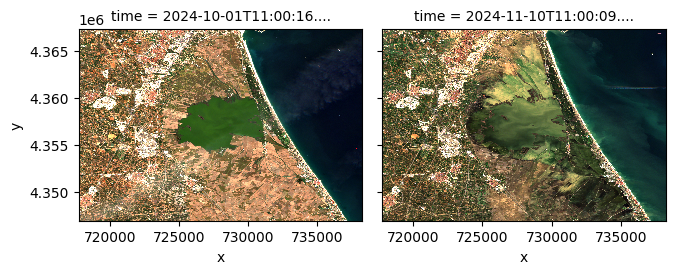

In [ ]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

## Prepare metadata required by the model and data transformation pipeline

We prepare a transform pipeline to perfrom Normalization using the mean and std of the bands

In [ ]:
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("./clay/configs/metadata.yaml")))
mean = []
std = []
waves = []
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)
print(transform)

Compose(    Normalize(mean=[1105.0, 1355.0, 1552.0, 2743.0, 2422.0, 2388.0], std=[1809.0, 1757.0, 1888.0, 1742.0, 1732.0, 1470.0], inplace=False))
Current memory usage: 2.45 GB


In [ ]:
print (mean)
print (std)
print (waves)

[1105.0, 1355.0, 1552.0, 2743.0, 2422.0, 2388.0]
[1809.0, 1757.0, 1888.0, 1742.0, 1732.0, 1470.0]
[0.493, 0.56, 0.665, 0.842, 0.74, 1.61]
Current memory usage: 2.45 GB


## Create patches from the Sentinel-2 images of size 256x256

Lets start with the first image before the flood. We have to transform the original image to 256x256 patches so we can pass the image through the Clay model 

In [ ]:
pixels_before_s2 = torch.from_numpy(stack.sel(time="2024-10-01").data.astype(np.float32))
print (f"The original shape of the image is --> (batch_size={pixels_before_s2.shape[0]}, bands={pixels_before_s2.shape[1]}, height={pixels_before_s2.shape[2]}, width={pixels_before_s2.shape[3]})")
batch_size, bands, height, width = pixels_before_s2.shape
patches_before_s2 = F.unfold(
    pixels_before_s2, kernel_size=PATCH_SIZE, stride=STRIDE
)  # (BATCH, BANDS*PATCH_SIZE*PATCH_SIZE, NUM_PATCHES)
patches_before_s2 = patches_before_s2.permute(0, 2, 1)  # (BATCH, NUM_PATCHES, BANDS*PATCH_SIZE*PATCH_SIZE)
patches_before_s2 = patches_before_s2.view(
    batch_size, -1, bands, PATCH_SIZE, PATCH_SIZE
)  # (BATCH, NUM_PATCHES, BANDS, PATCH_SIZE, PATCH_SIZE)
patches_before_s2 = patches_before_s2.reshape(-1, bands, PATCH_SIZE, PATCH_SIZE)
print(f"After all the transformations the shape becomes --> (number of patches={patches_before_s2.shape[0]}, bands={patches_before_s2.shape[1]}, patch size={patches_before_s2.shape[2]}, patch size={patches_before_s2.shape[3]})")

The original shape of the image is --> (batch_size=1, bands=6, height=2048, width=2048)
After all the transformations the shape becomes --> (number of patches=64, bands=6, patch size=256, patch size=256)
Current memory usage: 2.64 GB


We will perform the exact same transformations to the second image after the flood

In [ ]:
pixels_after_s2 = torch.from_numpy(stack.sel(time="2024-11-10").data.astype(np.float32))
print (f"The original shape of the image is --> (batch_size={pixels_after_s2.shape[0]}, bands={pixels_after_s2.shape[1]}, height={pixels_after_s2.shape[2]}, width={pixels_after_s2.shape[3]})")
batch_size, bands, height, width = pixels_after_s2.shape
patches_after_s2 = F.unfold(
    pixels_after_s2, kernel_size=PATCH_SIZE, stride=STRIDE
)  # (BATCH, BANDS*PATCH_SIZE*PATCH_SIZE, NUM_PATCHES)
patches_after_s2 = patches_after_s2.permute(
    0, 2, 1
)  # (BATCH, NUM_PATCHES, BANDS*PATCH_SIZE*PATCH_SIZE)
patches_after_s2 = patches_after_s2.view(
    batch_size, -1, bands, PATCH_SIZE, PATCH_SIZE
)  # (BATCH, NUM_PATCHES, BANDS, PATCH_SIZE, PATCH_SIZE)
patches_after_s2 = patches_after_s2.reshape(-1, bands, PATCH_SIZE, PATCH_SIZE)
print(f"After all the transformations the shape becomes --> (number of patches={patches_after_s2.shape[0]}, bands={patches_after_s2.shape[1]}, patch size={patches_after_s2.shape[2]}, patch size={patches_after_s2.shape[3]})")

The original shape of the image is --> (batch_size=1, bands=6, height=2048, width=2048)
After all the transformations the shape becomes --> (number of patches=64, bands=6, patch size=256, patch size=256)
Current memory usage: 2.82 GB


## Get centers and timestamps for the image patches

For each patch, calculate the center of it and the timestamp

In [ ]:
x_coords = stack.coords["x"].values
y_coords = stack.coords["y"].values
time_values = stack.coords["time"].values.astype("datetime64[s]")
img_id_values = stack.id.values
height, width = pixels_before_s2.shape[-2:]  # Get spatial dimensions
patch_centers_x_idx = np.arange(PATCH_SIZE // 2, width, STRIDE)  # X indices of centers
patch_centers_y_idx = np.arange(PATCH_SIZE // 2, height, STRIDE)  # Y indices of centers

center_x_grid, center_y_grid = np.meshgrid(patch_centers_x_idx, patch_centers_y_idx)
center_x_coords = x_coords[center_x_grid]  # Map X indices to coordinates
center_y_coords = y_coords[center_y_grid]  # Map Y indices to coordinates

patch_centers = np.stack([center_x_coords.ravel(), center_y_coords.ravel()], axis=-1)
num_patches = len(patch_centers)
patches_per_image = num_patches // 18
timesteps_patches = (
    np.repeat(time_values, num_patches).astype("datetime64[ms]").tolist()
)
img_id_patches = np.repeat(img_id_values, num_patches).tolist()
original_crs = stack.attrs["crs"]  # Assuming you are using a rioxarray-enabled dataset
target_crs = "EPSG:4326"  # WGS 84
transformer = pyproj.Transformer.from_crs(original_crs, target_crs, always_xy=True)
x_coords = patch_centers[:, 0]
y_coords = patch_centers[:, 1]
lon, lat = transformer.transform(x_coords, y_coords)
patch_centers_epsg4326 = np.stack([lon, lat], axis=-1)
patch_centers_epsg4326_all = np.array([patch_centers_epsg4326] * batch_size).reshape(
    batch_size * num_patches, 2
)

Current memory usage: 2.82 GB


## Visualize the patch centers on a map

In [ ]:
# Initialize a folium map centered at the average location of your patch centers
map_center = [
    np.mean([coord[1] for coord in patch_centers_epsg4326[0:64]]),  # Average latitude
    np.mean([coord[0] for coord in patch_centers_epsg4326[0:64]]),  # Average longitude
]

m = folium.Map(location=map_center, zoom_start=10)

# Add a circle marker for each patch center
for lon, lat in patch_centers_epsg4326[0:64]:
    folium.CircleMarker(
        location=[lat, lon],  # Note: folium uses (lat, lon)
        radius=5,  # Marker size
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
    ).add_to(m)
m

Current memory usage: 2.82 GB


## Normalize timestamps and coordinates as required by the model

In [ ]:
times = [normalize_timestamp(dat) for dat in timesteps_patches]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]
latlons = [normalize_latlon(lat, lon) for lat, lon in patch_centers_epsg4326_all]
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

Current memory usage: 2.82 GB


## Transform the data

After all the work its time to perform the final step before the data is ready to go through the model. This step is the normalization using the mean and std

In [ ]:
transformed_patches_before_s2 = transform(patches_before_s2)
transformed_patches_after_s2 = transform(patches_after_s2)
print(f"The final shape of our input is--> (number of patches={transformed_patches_before_s2.shape[0]}, bands={transformed_patches_before_s2.shape[1]}, patch size={transformed_patches_before_s2.shape[2]}, patch size={transformed_patches_before_s2.shape[3]})")

The final shape of our input is--> (number of patches=64, bands=6, patch size=256, patch size=256)
Current memory usage: 3.01 GB


## Initialize the model

In [ ]:
model = ClayMAEModule(
    model_size="large",
    metadata_path="./clay/configs/metadata.yaml",
    dolls=[16, 32, 64, 128, 256, 768, 1024],
    doll_weights=[1, 1, 1, 1, 1, 1, 1],
    mask_ratio=0.0,
    shuffle=False,
)

RuntimeError: Error(s) in loading state_dict for ClayMAE:
	size mismatch for decoder.transformer.layers.0.0.to_qkv.weight: copying a param with shape torch.Size([1152, 512]) from checkpoint, the shape in current model is torch.Size([768, 512]).
	size mismatch for decoder.transformer.layers.0.0.to_out.weight: copying a param with shape torch.Size([512, 384]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for decoder.transformer.layers.1.0.to_qkv.weight: copying a param with shape torch.Size([1152, 512]) from checkpoint, the shape in current model is torch.Size([768, 512]).
	size mismatch for decoder.transformer.layers.1.0.to_out.weight: copying a param with shape torch.Size([512, 384]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for decoder.transformer.layers.2.0.to_qkv.weight: copying a param with shape torch.Size([1152, 512]) from checkpoint, the shape in current model is torch.Size([768, 512]).
	size mismatch for decoder.transformer.layers.2.0.to_out.weight: copying a param with shape torch.Size([512, 384]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for decoder.transformer.layers.3.0.to_qkv.weight: copying a param with shape torch.Size([1152, 512]) from checkpoint, the shape in current model is torch.Size([768, 512]).
	size mismatch for decoder.transformer.layers.3.0.to_out.weight: copying a param with shape torch.Size([512, 384]) from checkpoint, the shape in current model is torch.Size([512, 256]).

We set the model to evaluation mode and move it to the device

In [ ]:
ckpt = "./clay/clay-v1.5.ckpt"
torch.set_default_device(DEVICE)
model.eval()
model = model.to(DEVICE)

Current memory usage: 9.82 GB
SURPASSED MEMORY


## Inference on the before image

In [ ]:
before_embeddings_s2 = []
m_batch_size = 16
for start_idx in tqdm(
    range(0, transformed_patches_before_s2.size(0), m_batch_size),
    desc="Processing batches",
):
    end_idx = min(start_idx + m_batch_size, transformed_patches_before_s2.size(0))
    datacube = {
        "platform": platform,
        "time": torch.tensor(
            np.hstack((week_norm[start_idx:end_idx], hour_norm[start_idx:end_idx])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm[start_idx:end_idx], lon_norm[start_idx:end_idx])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "pixels": transformed_patches_before_s2[start_idx:end_idx].to(DEVICE),
        "gsd": torch.tensor(
            [metadata[platform].gsd], dtype=torch.float32, device=DEVICE
        ),
        "waves": torch.tensor(waves, device=DEVICE),
    }
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)
        before_embeddings_s2.append(unmsk_patch)

Processing batches: 100%|██████████| 4/4 [01:26<00:00, 21.73s/it]

Current memory usage: 9.84 GB
SURPASSED MEMORY


## Inference on the after image

In [ ]:
after_embeddings_s2 = []
m_batch_size = 16
for start_idx in tqdm(
    range(0, transformed_patches_after_s2.size(0), m_batch_size),
    desc="Processing batches",
):
    end_idx = min(start_idx + m_batch_size, transformed_patches_after_s2.size(0))
    datacube = {
        "platform": platform,
        "time": torch.tensor(
            np.hstack((week_norm[start_idx+64:end_idx+64], hour_norm[start_idx+64:end_idx+64])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm[start_idx:end_idx], lon_norm[start_idx:end_idx])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "pixels": transformed_patches_after_s2[start_idx:end_idx].to(DEVICE),
        "gsd": torch.tensor(
            [metadata[platform].gsd], dtype=torch.float32, device=DEVICE
        ),
        "waves": torch.tensor(waves, device=DEVICE),
    }
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)
        after_embeddings_s2.append(unmsk_patch)

Processing batches: 100%|██████████| 4/4 [01:26<00:00, 21.51s/it]

Current memory usage: 9.84 GB
SURPASSED MEMORY


## Flatten the lists containing the image embeddings

In [ ]:
flattened_before_embeddings_s2 = torch.cat(before_embeddings_s2, dim=0)
flattened_after_embeddings_s2 = torch.cat(after_embeddings_s2, dim=0)
print(f"The shape of the results after the input has been passed through our model is --> (number of patches={flattened_before_embeddings_s2.shape[0]},height x widht={flattened_before_embeddings_s2.shape[1]}, embedding dimension={flattened_before_embeddings_s2.shape[2]})")

The shape of the results after the input has been passed through our model is --> (number of patches=64,height x widht=1025, embedding dimension=1024)
Current memory usage: 9.84 GB
SURPASSED MEMORY


## Visualize an example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.047500003..1.0550001].


Patch ID: 44


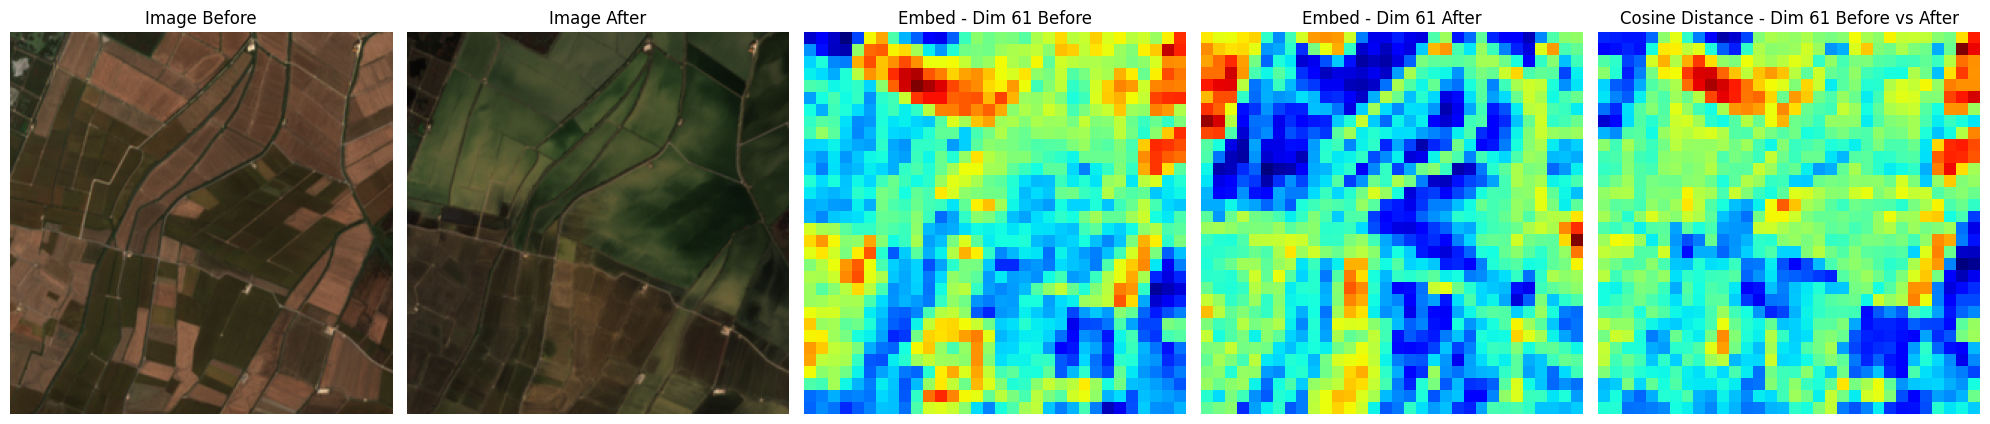

Current memory usage: 9.84 GB
SURPASSED MEMORY


In [ ]:
patch_id = np.random.randint(0,transformed_patches_before_s2.shape[0])
print(f"Patch ID: {patch_id}")
embed_id = (
    61  # random.sample(range(1024), 4) # [61,62,63,64]  # pick any embedding dimensions
)
img_before_s2 = transformed_patches_before_s2[patch_id].detach().cpu().numpy()
img_after_s2 = transformed_patches_after_s2[patch_id].detach().cpu().numpy()
embedding_before_s2 = flattened_before_embeddings_s2[patch_id]
embedding_after_s2 = flattened_after_embeddings_s2[patch_id]
img_before_s2 = denormalize_images(img_before_s2, mean, std)
img_before_s2 = (img_before_s2 / 10000).astype(np.float32)
img_after_s2 = denormalize_images(img_after_s2, mean, std)
img_after_s2 = (img_after_s2 / 10000).astype(np.float32)
unmsk_embed_before_s2 = rearrange_embeddings(embedding_before_s2.unsqueeze(0))
unmsk_embed_after_s2 = rearrange_embeddings(embedding_after_s2.unsqueeze(0))
fig, axs = plt.subplots(1, 5, figsize=(20, 14))
axs[0].imshow(img_before_s2[0, [2, 1, 0], ...].transpose(1, 2, 0) * 2.5)
axs[0].set_axis_off()
axs[0].set_title(f"Image Before")
axs[1].imshow(img_after_s2[0, [2, 1, 0], ...].transpose(1, 2, 0) * 2.5)
axs[1].set_axis_off()
axs[1].set_title(f"Image After")
axs[2].imshow(unmsk_embed_before_s2[0, embed_id], cmap="jet")
axs[2].set_axis_off()
axs[2].set_title(f"Embed - Dim {embed_id} Before")
axs[3].imshow(unmsk_embed_after_s2[0, embed_id], cmap="jet")
axs[3].set_axis_off()
axs[3].set_title(f"Embed - Dim {embed_id} After")
axs[4].imshow(
    pixelwise_cosine_distance_npy(
        unmsk_embed_before_s2,unmsk_embed_after_s2
    )[0],
    cmap="jet",
)
axs[4].set_axis_off()
axs[4].set_title(f"Cosine Distance - Dim {embed_id} Before vs After")
plt.tight_layout()
plt.show()

## Rearrange embeddings, compute difference matrix and interpolate to original patch size

In [ ]:
# We rearrange the embeddings to bring them in the required shape of the pixelwise cosine distance function
re_after_embeddings_s2 = rearrange_embeddings(flattened_after_embeddings_s2)
re_before_embeddings_s2 = rearrange_embeddings(flattened_before_embeddings_s2)
print(f"The shape of the embeddings after rearranging them is --> (number of patches={re_after_embeddings_s2.shape[0]},embeddings dimension={re_after_embeddings_s2.shape[1]}, height={re_after_embeddings_s2.shape[2]}, width={re_after_embeddings_s2.shape[3]})")
# We calculate pixelwise cosine distance
diff_s2 = pixelwise_cosine_distance_torch(torch.from_numpy(re_after_embeddings_s2), torch.from_numpy(re_before_embeddings_s2))
print(f"The resulting shape is --> (number of patches={diff_s2.shape[0]},height={diff_s2.shape[1]}, width={diff_s2.shape[2]})")

The shape of the embeddings after rearranging them is --> (number of patches=64,embeddings dimension=1024, height=32, width=32)
The resulting shape is --> (number of patches=64,height=32, width=32)
Current memory usage: 9.84 GB
SURPASSED MEMORY


In [ ]:
# We use interpolate of the difference to bring it to the required shape so we can pass it throught the reconstruct_image_from_patches fuction
# We use as size 256 cause thats what we set as PATCH_SIZE at the first cells
diff_s2 = F.interpolate(
    diff_s2.unsqueeze(1), size=(256, 256), mode="bilinear", align_corners=False
)
print(f"After the interpolation the new shape is --> (number of patches={diff_s2.shape[0]},channels={diff_s2.shape[1]}, patch_size={diff_s2.shape[2]}, patch_size={diff_s2.shape[3]})")

After the interpolation the new shape is --> (number of patches=64,channels=1, patch_size=256, patch_size=256)
Current memory usage: 9.84 GB
SURPASSED MEMORY


## Reconstruct diff in original image size and visualize

In [ ]:
diff_s2 = diff_s2.to(DEVICE)
recon_diff_s2 = reconstruct_image_from_patches(
    diff_s2, (2048, 2048), PATCH_SIZE, STRIDE, channels=1
)
print(f"After the recontruction the new shape is --> (channels={diff_s2.shape[0]},height={diff_s2.shape[1]}, width={diff_s2.shape[2]})")

After the recontruction the new shape is --> (channels=64,height=1, width=256)
Current memory usage: 9.84 GB
SURPASSED MEMORY


We visualise three images
- The RGB image before the flood
- The RGB image after the flood
- The pixelwise cosine difference of the before and after embeddings

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


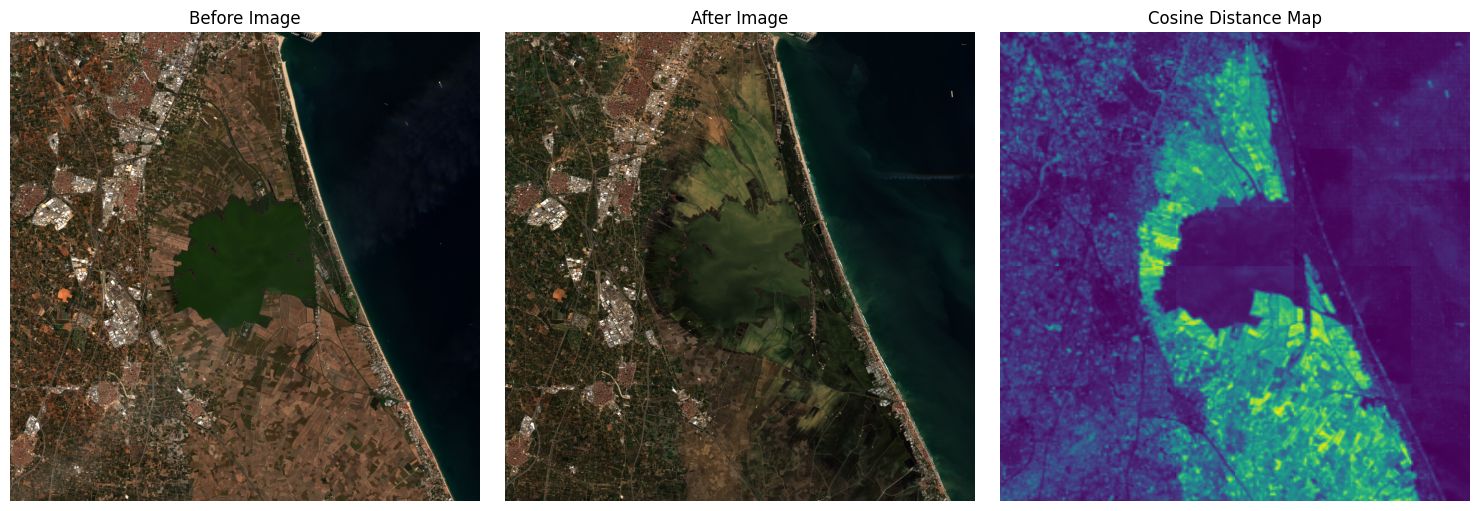

Current memory usage: 9.84 GB
SURPASSED MEMORY


In [ ]:
pixels_before_rgb_s2 = pixels_before_s2[0, [2, 1, 0], :, :].cpu().numpy()/10000.0
pixels_after_rgb_s2 = pixels_after_s2[0, [2, 1, 0], :, :].cpu().numpy()/10000.0

pixels_before_rgb_s2 = np.transpose(pixels_before_rgb_s2, (1, 2, 0))
pixels_after_rgb_s2 = np.transpose(pixels_after_rgb_s2, (1, 2, 0))

pixels_before_rgb_s2 = np.clip(pixels_before_rgb_s2, 0, 1)
pixels_after_rgb_s2 = np.clip(pixels_after_rgb_s2, 0, 1)


diff_map_s2 = recon_diff_s2.squeeze(-1)

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(pixels_before_rgb_s2*2.5)
plt.title("Before Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pixels_after_rgb_s2*2.5)
plt.title("After Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_map_s2, cmap="viridis")
plt.title("Cosine Distance Map")
plt.axis("off")

plt.tight_layout()
plt.show()

# Change Detection Using Sentinel-1 Images

## Search STAC API for Sentinel-1 images

In [ ]:
response = requests.get(f"{PLANETARY_TOKEN_URL}/{COLLECTION_S1}")

if response.status_code == 200:
    response = response.json()  # Assuming the response contains a JSON object
    token = response["token"]
    headers ={"Authorization":f"Bearer {token}"}
else:
    print(f"Failed to get token. Status code: {response.status_code}")
    exit()

# Search the catalogue
catalog = pystac_client.Client.open(PLANETARY_STAC_API)
search = catalog.search(
    collections=[COLLECTION_S1],
    datetime=f"{START_DATE_S1}/{END_DATE_S1}",
    bbox=(LON - 1e-3, LAT - 1e-3, LON + 1e-3, LAT + 1e-3),
    )
all_items = search.get_all_items()
items = []
dates = []
for item in all_items:
    item_date = item.datetime
    if item_date.date() not in dates  and item.properties["sat:orbit_state"]=="ascending" and (item_date.isoformat()[0:10] == BEFORE_DATE_S1 or item_date.isoformat()[0:10] == AFTER_DATE_S1) :
        items.append(planetary_computer.sign_item(item))
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

/mnt/hdd1/diogenis/ellis_notebooks/.ellis/lib/python3.10/site-packages/pystac_client/item_search.py:940: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 2 items
Current memory usage: 9.84 GB
SURPASSED MEMORY


## Create a bounding box around POI

In [ ]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:code"]

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(LON, LAT)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 2048
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

Current memory usage: 9.84 GB
SURPASSED MEMORY


## Get the Sentinel-1 data using StackStac

In [ ]:
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=int(epsg.split(":")[-1]),
    resolution=gsd,
    dtype="float64",
    rescale=False,
    # fill_value=np.nan,
    assets=["vv", "vh"],
    resampling=Resampling.nearest,
)
stack = stack.compute()

Current memory usage: 9.58 GB
SURPASSED MEMORY


## Convert Sentinel-1 data from linear intensity to decibel (dB)

In [ ]:
eps = 1e-10
stack_db = 10 * np.log10(stack + eps)

Current memory usage: 9.58 GB
SURPASSED MEMORY


## Visualize Sentinel-1 data

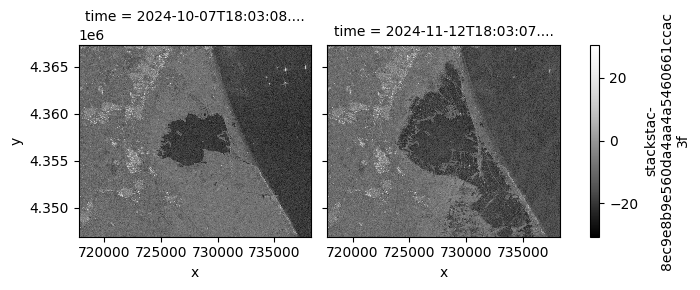

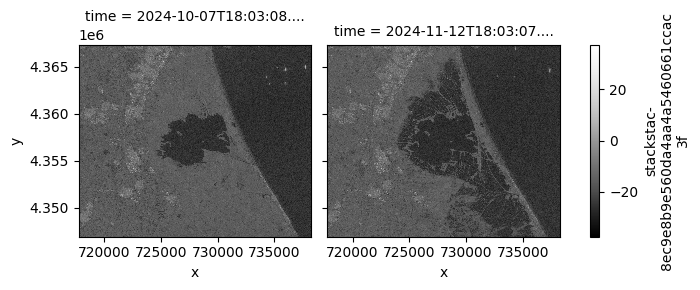

Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
stack_db.sel(band="vv").plot.imshow(
    row="time",
    col_wrap=2,
    cmap=plt.cm.Greys_r,
)

# Plot VH Band with its own scaling
stack_db.sel(band="vh").plot.imshow(
    row="time",
    col_wrap=2,
    cmap=plt.cm.Greys_r,
)

plt.show()

## Prepare metadata required for the model and the transformation pipeline

In [ ]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-1-rtc"
metadata = Box(yaml.safe_load(open("./clay/configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack_db.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
pixels_before_s1 = torch.from_numpy(stack_db.sel(time="2024-10-07").data.astype(np.float32))
print (f"The original shape of the image is --> (batch_size={pixels_before_s1.shape[0]}, bands={pixels_before_s1.shape[1]}, height={pixels_before_s1.shape[2]}, width={pixels_before_s1.shape[3]})")
batch_size, bands, height, width = pixels_before_s1.shape
patches_before_s1 = F.unfold(
    pixels_before_s1, kernel_size=PATCH_SIZE, stride=STRIDE
)  # (BATCH, BANDS*PATCH_SIZE*PATCH_SIZE, NUM_PATCHES)
patches_before_s1 = patches_before_s1.permute(
    0, 2, 1
)  # (BATCH, NUM_PATCHES, BANDS*PATCH_SIZE*PATCH_SIZE)
patches_before_s1 = patches_before_s1.view(
    batch_size, -1, bands, PATCH_SIZE, PATCH_SIZE
)  # (BATCH, NUM_PATCHES, BANDS, PATCH_SIZE, PATCH_SIZE)
patches_before_s1 = patches_before_s1.reshape(-1, bands, PATCH_SIZE, PATCH_SIZE)
print(f"After all the transformations the shape becomes --> (number of patches={patches_before_s1.shape[0]}, bands={patches_before_s1.shape[1]}, patch size={patches_before_s1.shape[2]}, patch size={patches_before_s1.shape[3]})")

The original shape of the image is --> (batch_size=1, bands=2, height=2048, width=2048)
After all the transformations the shape becomes --> (number of patches=64, bands=2, patch size=256, patch size=256)
Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
pixels_after_s1 = torch.from_numpy(stack_db.sel(time="2024-11-12").data.astype(np.float32))
print (f"The original shape of the image is --> (batch_size={pixels_after_s1.shape[0]}, bands={pixels_after_s1.shape[1]}, height={pixels_after_s1.shape[2]}, width={pixels_after_s1.shape[3]})")
batch_size, bands, height, width = pixels_after_s1.shape
patches_after_s1 = F.unfold(
    pixels_after_s1, kernel_size=PATCH_SIZE, stride=STRIDE
)  # (BATCH, BANDS*PATCH_SIZE*PATCH_SIZE, NUM_PATCHES)
patches_after_s1 = patches_after_s1.permute(
    0, 2, 1
)  # (BATCH, NUM_PATCHES, BANDS*PATCH_SIZE*PATCH_SIZE)
patches_after_s1 = patches_after_s1.view(
    batch_size, -1, bands, PATCH_SIZE, PATCH_SIZE
)  # (BATCH, NUM_PATCHES, BANDS, PATCH_SIZE, PATCH_SIZE)
patches_after_s1 = patches_after_s1.reshape(-1, bands, PATCH_SIZE, PATCH_SIZE)
print(f"After all the transformations the shape becomes --> (number of patches={patches_after_s1.shape[0]}, bands={patches_after_s1.shape[1]}, patch size={patches_after_s1.shape[2]}, patch size={patches_after_s1.shape[3]})")

The original shape of the image is --> (batch_size=1, bands=2, height=2048, width=2048)
After all the transformations the shape becomes --> (number of patches=64, bands=2, patch size=256, patch size=256)
Current memory usage: 9.59 GB
SURPASSED MEMORY


## Get centers and timestamps of the patches

In [ ]:
x_coords = stack_db.coords["x"].values
y_coords = stack_db.coords["y"].values
time_values = stack_db.coords["time"].values.astype("datetime64[s]")
img_id_values = stack_db.id.values
height, width = pixels_before_s1.shape[-2:]  # Get spatial dimensions
patch_centers_x_idx = np.arange(PATCH_SIZE // 2, width, STRIDE)  # X indices of centers
patch_centers_y_idx = np.arange(PATCH_SIZE // 2, height, STRIDE)  # Y indices of centers

center_x_grid, center_y_grid = np.meshgrid(patch_centers_x_idx, patch_centers_y_idx)
center_x_coords = x_coords[center_x_grid]  # Map X indices to coordinates
center_y_coords = y_coords[center_y_grid]  # Map Y indices to coordinates

patch_centers = np.stack([center_x_coords.ravel(), center_y_coords.ravel()], axis=-1)
num_patches = len(patch_centers)
patches_per_image = num_patches // 18
timesteps_patches = (
    np.repeat(time_values, num_patches).astype("datetime64[ms]").tolist()
)
img_id_patches = np.repeat(img_id_values, num_patches).tolist()
original_crs = stack.attrs["crs"]  # Assuming you are using a rioxarray-enabled dataset
target_crs = "EPSG:4326"  # WGS 84
transformer = pyproj.Transformer.from_crs(original_crs, target_crs, always_xy=True)
x_coords = patch_centers[:, 0]
y_coords = patch_centers[:, 1]
lon, lat = transformer.transform(x_coords, y_coords)
patch_centers_epsg4326 = np.stack([lon, lat], axis=-1)
patch_centers_epsg4326_all = np.array([patch_centers_epsg4326] * batch_size).reshape(
    batch_size * num_patches, 2
)

Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
# Initialize a folium map centered at the average location of your patch centers
map_center = [
    np.mean([coord[1] for coord in patch_centers_epsg4326[0:64]]),  # Average latitude
    np.mean([coord[0] for coord in patch_centers_epsg4326[0:64]]),  # Average longitude
]

m = folium.Map(location=map_center, zoom_start=10)

# Add a circle marker for each patch center
for lon, lat in patch_centers_epsg4326[0:64]:
    folium.CircleMarker(
        location=[lat, lon],  # Note: folium uses (lat, lon)
        radius=5,  # Marker size
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
    ).add_to(m)
m

Current memory usage: 9.59 GB
SURPASSED MEMORY


## Normalize timestamps and coordinates

In [ ]:
times = [normalize_timestamp(dat) for dat in timesteps_patches]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]
latlons = [normalize_latlon(lat, lon) for lat, lon in patch_centers_epsg4326_all]
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

Current memory usage: 9.59 GB
SURPASSED MEMORY


## Transform Sentinel-1 data

In [ ]:
transformed_patches_before_s1 = transform(patches_before_s1)
transformed_patches_after_s1 = transform(patches_after_s1)
print(f"The final shape of our input is--> (number of patches={transformed_patches_before_s1.shape[0]}, bands={transformed_patches_before_s1.shape[1]}, patch size={transformed_patches_before_s1.shape[2]}, patch size={transformed_patches_before_s1.shape[3]})")

The final shape of our input is--> (number of patches=64, bands=2, patch size=256, patch size=256)
Current memory usage: 9.59 GB
SURPASSED MEMORY


## Inference on the before image

In [ ]:
before_embeddings_s1 = []
m_batch_size = 16
for start_idx in tqdm(
    range(0, transformed_patches_before_s1.size(0), m_batch_size),
    desc="Processing batches",
):
    end_idx = min(start_idx + m_batch_size, transformed_patches_before_s1.size(0))
    datacube = {
        "platform": platform,
        "time": torch.tensor(
            np.hstack((week_norm[start_idx:end_idx], hour_norm[start_idx:end_idx])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm[start_idx:end_idx], lon_norm[start_idx:end_idx])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "pixels": transformed_patches_before_s1[start_idx:end_idx].to(DEVICE),
        "gsd": torch.tensor(
            [metadata[platform].gsd], dtype=torch.float32, device=DEVICE
        ),
        "waves": torch.tensor(waves, device=DEVICE),
    }
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)
        before_embeddings_s1.append(unmsk_patch)

Processing batches: 100%|██████████| 4/4 [01:25<00:00, 21.38s/it]

Current memory usage: 9.59 GB
SURPASSED MEMORY


## Inference on the after image

In [ ]:
after_embeddings_s1 = []
m_batch_size = 16
for start_idx in tqdm(
    range(0, transformed_patches_after_s1.size(0), m_batch_size),
    desc="Processing batches",
):
    end_idx = min(start_idx + m_batch_size, transformed_patches_after_s1.size(0))
    datacube = {
        "platform": platform,
        "time": torch.tensor(
            np.hstack(
                (
                    week_norm[start_idx + 64 : end_idx + 64],
                    hour_norm[start_idx + 64 : end_idx + 64],
                )
            ),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm[start_idx:end_idx], lon_norm[start_idx:end_idx])),
            dtype=torch.float32,
            device=DEVICE,
        ),
        "pixels": transformed_patches_after_s1[start_idx:end_idx].to(DEVICE),
        "gsd": torch.tensor(
            [metadata[platform].gsd], dtype=torch.float32, device=DEVICE
        ),
        "waves": torch.tensor(waves, device=DEVICE),
    }
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)
        after_embeddings_s1.append(unmsk_patch)

Processing batches: 100%|██████████| 4/4 [01:25<00:00, 21.41s/it]

Current memory usage: 9.59 GB
SURPASSED MEMORY


## Flatten the lists containing the embeddings

In [ ]:
flattened_before_embeddings_s1 = torch.cat(before_embeddings_s1, dim=0)
flattened_after_embeddings_s1 = torch.cat(after_embeddings_s1, dim=0)
print(f"The shape of the results after the input has been passed through our model is --> (number of patches={flattened_before_embeddings_s1.shape[0]},height x widht={flattened_before_embeddings_s1.shape[1]}, embedding dimension={flattened_before_embeddings_s1.shape[2]})")

The shape of the results after the input has been passed through our model is --> (number of patches=64,height x widht=1025, embedding dimension=1024)
Current memory usage: 9.59 GB
SURPASSED MEMORY


## Visualize an example

Patch ID: 0


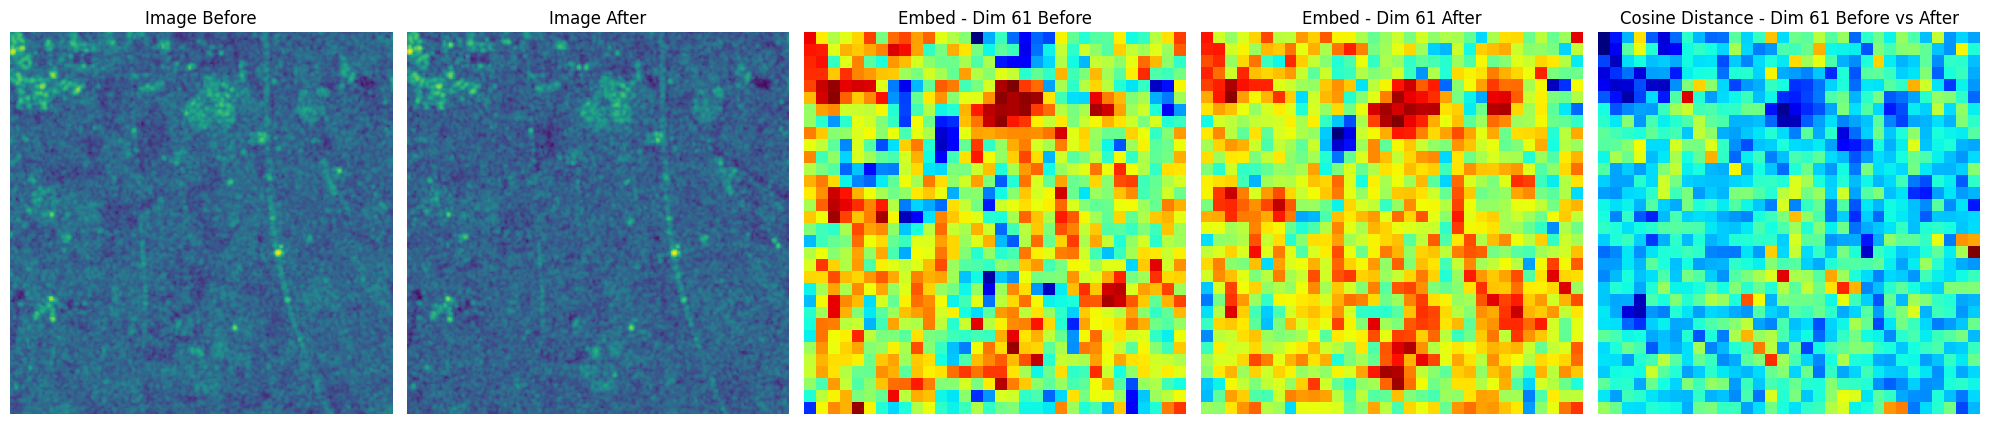

Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
patch_id = np.random.randint(0, transformed_patches_before_s1.shape[0])
# patch_id = 61
print(f"Patch ID: {patch_id}")
embed_id = (
    61  # random.sample(range(1024), 4) # [61,62,63,64]  # pick any embedding dimensions
)
img_before_s1 = transformed_patches_before_s1[patch_id].detach().cpu().numpy()
img_after_s1 = transformed_patches_after_s1[patch_id].detach().cpu().numpy()
embedding_before_s1 = flattened_before_embeddings_s1[patch_id]
embedding_after_s1 = flattened_after_embeddings_s1[patch_id]
img_before_s1 = denormalize_images(img_before_s1, mean, std)
img_before_s1 = (img_before_s1 / 10000).astype(np.float32)
img_after_s1 = denormalize_images(img_after_s1, mean, std)
img_after_s1 = (img_after_s1 / 10000).astype(np.float32)
unmsk_embed_before_s1 = rearrange_embeddings(embedding_before_s1.unsqueeze(0))
unmsk_embed_after_s1 = rearrange_embeddings(embedding_after_s1.unsqueeze(0))
fig, axs = plt.subplots(1, 5, figsize=(20, 14))
axs[0].imshow(img_before_s1[0,0, ...])
axs[0].set_axis_off()
axs[0].set_title(f"Image Before")
axs[1].imshow(img_after_s1[0, 0, ...])
axs[1].set_axis_off()
axs[1].set_title(f"Image After")
axs[2].imshow(unmsk_embed_before_s1[0, embed_id], cmap="jet")
axs[2].set_axis_off()
axs[2].set_title(f"Embed - Dim {embed_id} Before")
axs[3].imshow(unmsk_embed_after_s1[0, embed_id], cmap="jet")
axs[3].set_axis_off()
axs[3].set_title(f"Embed - Dim {embed_id} After")
axs[4].imshow(
    pixelwise_cosine_distance_npy(unmsk_embed_before_s1, unmsk_embed_after_s1)[0],
    cmap="jet",
)
axs[4].set_axis_off()
axs[4].set_title(f"Cosine Distance - Dim {embed_id} Before vs After")
plt.tight_layout()
plt.show()

## Rearrange embeddings, compute distance matrix and interpolate

In [ ]:
re_after_embeddings_s1 = rearrange_embeddings(flattened_after_embeddings_s1)
re_before_embeddings_s1 = rearrange_embeddings(flattened_before_embeddings_s1)
print(f"The shape of the embeddings after rearranging them is --> (number of patches={re_after_embeddings_s1.shape[0]},embeddings dimension={re_after_embeddings_s1.shape[1]}, height={re_after_embeddings_s1.shape[2]}, width={re_after_embeddings_s1.shape[3]})")
diff_s1 = pixelwise_cosine_distance_torch(torch.from_numpy(re_after_embeddings_s1), torch.from_numpy(re_before_embeddings_s1))
print(f"The resulting shape is --> (number of patches={diff_s1.shape[0]},height={diff_s1.shape[1]}, width={diff_s1.shape[2]})")

The shape of the embeddings after rearranging them is --> (number of patches=64,embeddings dimension=1024, height=32, width=32)
The resulting shape is --> (number of patches=64,height=32, width=32)
Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
diff_s1 = F.interpolate(
    diff_s1.unsqueeze(1), size=(256, 256), mode="bilinear", align_corners=False
)
print(f"After the interpolation the new shape is --> (number of patches={diff_s1.shape[0]},channels={diff_s1.shape[1]}, patch_size={diff_s1.shape[2]}, patch_size={diff_s1.shape[3]})")

After the interpolation the new shape is --> (number of patches=64,channels=1, patch_size=256, patch_size=256)
Current memory usage: 9.59 GB
SURPASSED MEMORY


## Reconstruct the diff in original image size and visualize

In [ ]:
diff_s1 = diff_s1.to(DEVICE)
recon_diff_s1 = reconstruct_image_from_patches(
    diff_s1, (2048, 2048), PATCH_SIZE, STRIDE, channels=1
)
print(f"After the recontruction the new shape is --> (channels={diff_s1.shape[0]},height={diff_s1.shape[1]}, width={diff_s1.shape[2]})")

After the recontruction the new shape is --> (channels=64,height=1, width=256)
Current memory usage: 9.59 GB
SURPASSED MEMORY


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


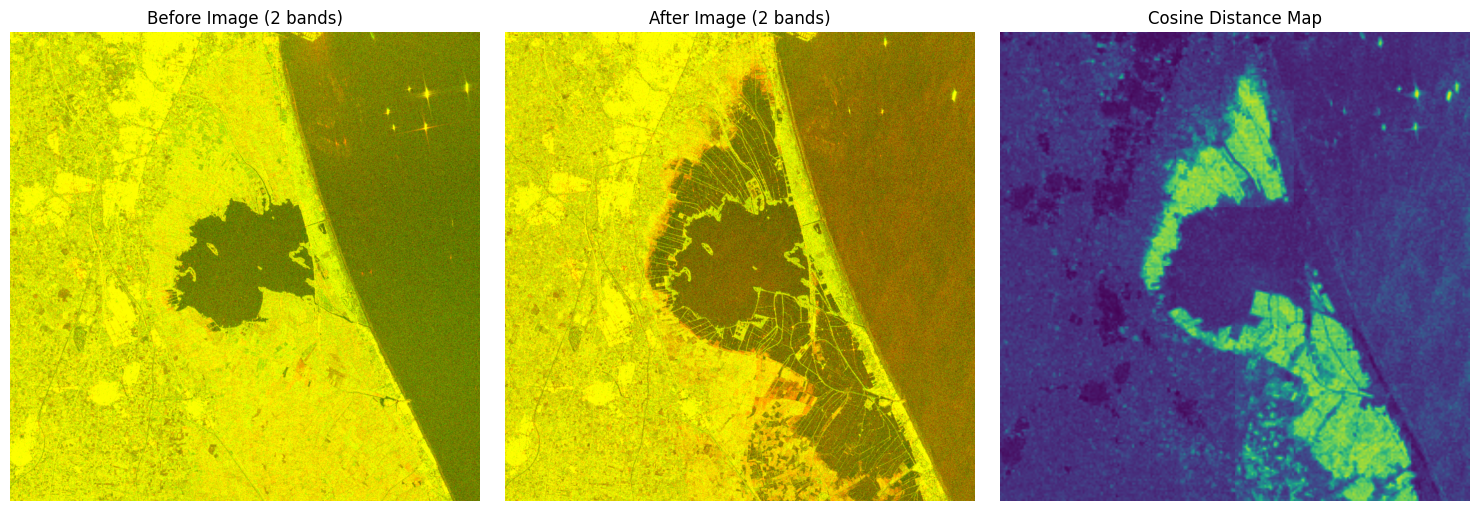

Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
def min_max_normalize(image):
    normalized = np.zeros_like(image)
    for band in range(image.shape[0]):
        band_min = image[band].min()
        band_max = image[band].max()
        normalized[band] = (image[band] - band_min) / (band_max - band_min + 1e-10)
    return normalized


pixels_before_np_s1 = pixels_before_s1[0, :, :, :].cpu().numpy()  # shape: (2, H, W)
pixels_after_np_s1 = pixels_after_s1[0, :, :, :].cpu().numpy()   # shape: (2, H, W)

pixels_before_np_s1 = min_max_normalize(pixels_before_np_s1)
pixels_after_np_s1 = min_max_normalize(pixels_after_np_s1)

# Create pseudo-RGB images by assigning band 0 -> R, band 1 -> G, and zero to B
H, W = pixels_before_np_s1.shape[1], pixels_before_np_s1.shape[2]

pixels_before_rgb_s1 = np.stack(
    [
        pixels_before_np_s1[0],  # Red
        pixels_before_np_s1[1],  # Green
        np.zeros((H, W)),  # Blue
    ],
    axis=-1,
)

pixels_after_rgb_s1 = np.stack(
    [pixels_after_np_s1[0], pixels_after_np_s1[1], np.zeros((H, W))],  # Red  # Green  # Blue
    axis=-1,
)

# Clip to [0, 1] for display
# pixels_before_rgb = np.clip(pixels_before_rgb, 0, 1)
# pixels_after_rgb = np.clip(pixels_after_rgb, 0, 1)

# Assuming diff_map is (H, W) or (H, W, 1)
diff_map_s1 = recon_diff_s1.squeeze()
if diff_map_s1.ndim == 3:
    diff_map_s1 = diff_map_s1.squeeze(-1)

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(pixels_before_rgb_s1 * 2.5)
plt.title("Before Image (2 bands)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pixels_after_rgb_s1 * 2.5)
plt.title("After Image (2 bands)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_map_s1, cmap="viridis")
plt.title("Cosine Distance Map")
plt.axis("off")

plt.tight_layout()
plt.show()

## Plot the representation diff in Sentinel1 before image and Sentinel2 after image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


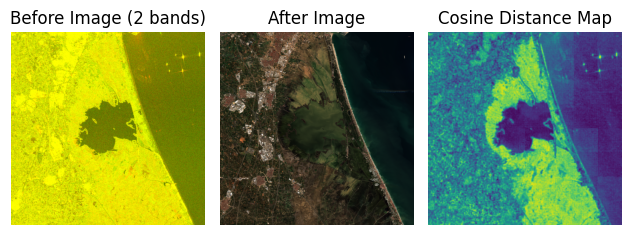

Current memory usage: 9.59 GB
SURPASSED MEMORY


In [ ]:
diff_s2_s1 = pixelwise_cosine_distance_torch(torch.from_numpy(re_after_embeddings_s2), torch.from_numpy(re_before_embeddings_s1))
diff_s2_s1 = F.interpolate(
    diff_s2_s1.unsqueeze(1), size=(256, 256), mode="bilinear", align_corners=False
)
diff_s2_s1 = diff_s2_s1.to(DEVICE)
recon_diff_s2_s1 = reconstruct_image_from_patches(
    diff_s2_s1, (2048, 2048), PATCH_SIZE, STRIDE, channels=1
)

diff_map_s2_s1 = recon_diff_s2_s1.squeeze()
if diff_map_s2_s1.ndim == 3:
    diff_map_s2_s1 = diff_map_s2_s1.squeeze(-1)
diff_map_s2_s1 = recon_diff_s2_s1.squeeze(-1)

plt.subplot(1, 3, 1)
plt.imshow(pixels_before_rgb_s1*2.5)
plt.title("Before Image (2 bands)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pixels_after_rgb_s2 * 2.5)
plt.title("After Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_map_s2_s1, cmap="viridis")
plt.title("Cosine Distance Map")
plt.axis("off")

plt.tight_layout()
plt.show()